In [1]:
import pandas as pd

df_results = pd.read_csv('../resources/data/unprocessed/MNCAATourneyCompactResults.csv')

df_results = df_results.loc[df_results['Season'] >= 2003, ].reset_index(drop=True)

df_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2003,134,1421,92,1411,84,N,1
1,2003,136,1112,80,1436,51,N,0
2,2003,136,1113,84,1272,71,N,0
3,2003,136,1141,79,1166,73,N,0
4,2003,136,1143,76,1301,74,N,1


In [2]:
import numpy as np

df = pd.DataFrame({'winner': np.repeat(0, df_results.shape[0]), 
                   'season': df_results['Season'], 
                   'day_number': df_results['DayNum'], 
                   'team0': df_results['WTeamID'], 
                   'team1': df_results['LTeamID']})

temp = pd.DataFrame({'winner': np.repeat(1, df_results.shape[0]), 
                     'season': df_results['Season'], 
                     'day_number': df_results['DayNum'], 
                     'team0': df_results['LTeamID'], 
                     'team1': df_results['WTeamID']})

df = pd.concat([df, temp], axis=0).reset_index(drop=True)

df.shape

(2496, 5)

In [3]:
df

,winner,season,day_number,team0,team1
0,0,2003,134,1421,1411
1,0,2003,136,1112,1436
2,0,2003,136,1113,1272
3,0,2003,136,1141,1166
4,0,2003,136,1143,1301
...,...,...,...,...,...
2491,1,2022,146,1274,1242
2492,1,2022,146,1389,1314
2493,1,2022,152,1437,1242
2494,1,2022,152,1181,1314


In [4]:
df_reg = pd.read_csv('../resources/data/unprocessed/MRegularSeasonCompactResults.csv')

df_reg = df_reg.loc[(df_reg['Season'] >= 2003) & (df_reg['Season'] != 2020), ].reset_index(drop=True)
df_reg.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2003,10,1104,68,1328,62,N,0
1,2003,10,1272,70,1393,63,N,0
2,2003,11,1266,73,1437,61,N,0
3,2003,11,1296,56,1457,50,N,0
4,2003,11,1400,77,1208,71,N,0


In [5]:
df_reg_reshape = pd.DataFrame({'season': df_reg['Season'], 
                               'team_id': df_reg['WTeamID'], 
                               'opponent_id': df_reg['LTeamID'], 
                               'result': np.repeat('win', df_reg.shape[0])})

temp =           pd.DataFrame({'season': df_reg['Season'], 
                               'team_id': df_reg['LTeamID'], 
                               'opponent_id': df_reg['WTeamID'], 
                               'result': np.repeat('loss', df_reg.shape[0])})

df_reg_reshape = pd.concat([df_reg_reshape, temp], axis=0).reset_index(drop=True)

df_reg_reshape

,season,team_id,opponent_id,result
0,2003,1104,1328,win
1,2003,1272,1393,win
2,2003,1266,1437,win
3,2003,1296,1457,win
4,2003,1400,1208,win
...,...,...,...,...
204607,2023,1401,1104,loss
204608,2023,1222,1272,loss
204609,2023,1463,1343,loss
204610,2023,1336,1345,loss


In [6]:
prev_matchups = np.array([
    (df_reg_reshape.loc[(df_reg_reshape['season'] == df.iloc[i, df.columns.get_loc('season')]) & 
                       (df_reg_reshape['team_id'] == df.iloc[i, df.columns.get_loc('team0')]) & 
                       (df_reg_reshape['opponent_id'] == df.iloc[i, df.columns.get_loc('team1')]), 'result'] == 'win').mean()
    for i in range(df.shape[0])
])

prev_matchups

array([nan, nan, nan, ..., nan, 0.5, nan])

In [7]:
def common_opponents(season, team0, team1, df_reg_reshape=df_reg_reshape):
    team0_opponents = set(df_reg_reshape.loc[(df_reg_reshape['season'] == season) & 
                                             (df_reg_reshape['team_id'] == team0), 'opponent_id'])
    team1_opponents = set(df_reg_reshape.loc[(df_reg_reshape['season'] == season) & 
                                             (df_reg_reshape['team_id'] == team1), 'opponent_id'])
    
    common_opps = team0_opponents.intersection(team1_opponents)
    
    team0_common_opps_win_pct = (df_reg_reshape.loc[(df_reg_reshape['season'] == season) & 
                                                    (df_reg_reshape['team_id'] == team0) & 
                                                    (df_reg_reshape['opponent_id'].isin(common_opps)), 'result'] == 'win').mean()
    
    team1_common_opps_win_pct = (df_reg_reshape.loc[(df_reg_reshape['season'] == season) & 
                                                    (df_reg_reshape['team_id'] == team1) & 
                                                    (df_reg_reshape['opponent_id'].isin(common_opps)), 'result'] == 'win').mean()
    
    return team1_common_opps_win_pct - team0_common_opps_win_pct

common_opponents(2013, 1104, 1328)

-0.25

In [8]:
common_opps_win_pct_diff = np.array([
    common_opponents(df.iloc[i, df.columns.get_loc('season')], 
                     df.iloc[i, df.columns.get_loc('team0')], 
                     df.iloc[i, df.columns.get_loc('team1')])
    for i in range(df.shape[0])
])

common_opps_win_pct_diff

array([        nan, -0.33333333,         nan, ..., -0.08333333,
       -0.0942029 ,  0.        ])

In [9]:
df['prev_matchups'] = prev_matchups
df['common_opps_win_pct_diff'] = common_opps_win_pct_diff

df.head()

,winner,season,day_number,team0,team1,prev_matchups,common_opps_win_pct_diff
0,0,2003,134,1421,1411,NaN,NaN
1,0,2003,136,1112,1436,NaN,-0.333333
2,0,2003,136,1113,1272,NaN,NaN
3,0,2003,136,1141,1166,NaN,0.000000
4,0,2003,136,1143,1301,NaN,NaN


In [10]:
def new_rating(winner_rating, loser_rating, winner_location):
    if winner_location == 'H':
        winner_expected = 1/(1 + 10**((loser_rating - winner_rating - 40)/400))
    elif winner_location == 'A':
        winner_expected = 1/(1 + 10**((loser_rating - winner_rating + 40)/400))
    else:
        winner_expected = 1/(1 + 10**((loser_rating - winner_rating)/400))
        
    new_winner_rating = winner_rating + (20*(1 - winner_expected))
    new_loser_rating = loser_rating - (new_winner_rating - winner_rating)
    
    return (new_winner_rating, new_loser_rating)
    # return winner_expected

new_rating(1000, 1002, 'A')

(1011.2030029046381, 990.7969970953619)

In [11]:
def season_ratings_iter(ratings, data):
    # avoid overwriting issues
    ratings = ratings.copy()
    data = data.copy()
    
    for i in range(data.shape[0]):
        winner = data.iloc[i, data.columns.get_loc('WTeamID')]
        loser = data.iloc[i, data.columns.get_loc('LTeamID')]

        winner_rating = ratings[winner]
        loser_rating = ratings[loser]
        winner_location = data.iloc[i, data.columns.get_loc('WLoc')]

        new_winner_rating, new_loser_rating = new_rating(winner_rating, loser_rating, winner_location)

        ratings[winner] = new_winner_rating
        ratings[loser] = new_loser_rating
        
    return ratings

In [12]:
def get_ratings(data, season):
    
    data = data.loc[data['Season'] == season, :].copy()

    teams = set(data['WTeamID'])
    teams.update(data['LTeamID'])

    ratings = dict(zip(teams, [1000 for _ in range(len(teams))]))
    new_ordinal_ratings = sorted(ratings, key=ratings.get, reverse=True)

    for i in range(10):
        old_ordinal_ratings = new_ordinal_ratings

        ratings = season_ratings_iter(ratings, data)

        new_ordinal_ratings = sorted(ratings, key=ratings.get, reverse=True)

    temp = pd.DataFrame({'season': season, 
                         'team_id': new_ordinal_ratings, 
                         'ordinal_rating': [i+1 for i, v in enumerate(new_ordinal_ratings)]})
    
    temp['rating'] = temp['team_id'].map(ratings)
    
    return temp

# get_ratings(df_reg, 2022)

In [13]:
ordinal_ratings = []

for season in df['season'].unique():
    print(season)
    
    ordinal_ratings.append(get_ratings(df_reg, season))
    
df_ratings = pd.concat(ordinal_ratings)

df_ratings

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2021
2022


,season,team_id,ordinal_rating,rating
0,2003,1246,1,1619.926118
1,2003,1112,2,1522.412523
2,2003,1338,3,1489.309025
3,2003,1328,4,1458.015924
4,2003,1393,5,1446.546717
...,...,...,...,...
353,2022,1183,354,501.652375
354,2022,1290,355,408.975854
355,2022,1237,356,347.420391
356,2022,1175,357,343.098097


In [14]:
team0_ELO = df.merge(df_ratings, how='left', 
                     left_on=['season', 'team0'], 
                     right_on=['season', 'team_id'])['rating']

team1_ELO = df.merge(df_ratings, how='left', 
                     left_on=['season', 'team1'], 
                     right_on=['season', 'team_id'])['rating']

df['elo_diff'] = team1_ELO - team0_ELO

team0_ordinal_ELO = df.merge(df_ratings, how='left', 
                     left_on=['season', 'team0'], 
                     right_on=['season', 'team_id'])['ordinal_rating']

team1_ordinal_ELO = df.merge(df_ratings, how='left', 
                     left_on=['season', 'team1'], 
                     right_on=['season', 'team_id'])['ordinal_rating']

df['ordinal_elo_diff'] = team1_ordinal_ELO - team0_ordinal_ELO

df

,winner,season,day_number,team0,team1,prev_matchups,common_opps_win_pct_diff,elo_diff,ordinal_elo_diff
0,0,2003,134,1421,1411,NaN,NaN,-31.631037,17
1,0,2003,136,1112,1436,NaN,-0.333333,-469.244650,133
2,0,2003,136,1113,1272,NaN,NaN,120.473581,-31
3,0,2003,136,1141,1166,NaN,0.000000,117.657793,-22
4,0,2003,136,1143,1301,NaN,NaN,-54.718516,22
...,...,...,...,...,...,...,...,...,...
2491,1,2022,146,1274,1242,NaN,0.000000,239.449424,-45
2492,1,2022,146,1389,1314,NaN,NaN,212.406858,-88
2493,1,2022,152,1437,1242,NaN,-0.083333,7.104325,-1
2494,1,2022,152,1181,1314,0.5,-0.094203,-85.575138,11


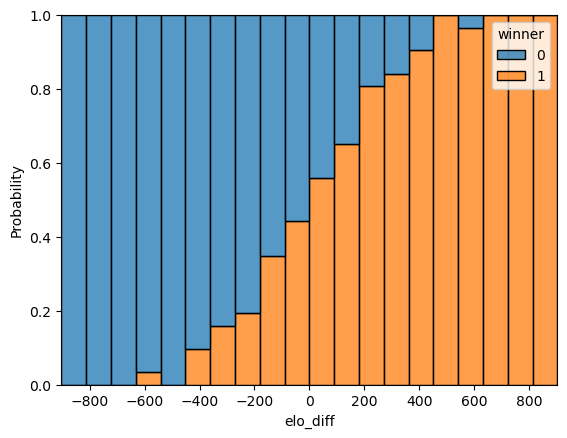

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

ax = sns.histplot(data=df, x='elo_diff', hue='winner', 
                  stat='probability', multiple='fill', bins=20)

ax.xaxis.set_major_locator(ticker.MultipleLocator(200))

plt.show()

In [17]:
def implied_odds(winner_rating, loser_rating, winner_location):
    if winner_location == 'H':
        winner_expected = 1/(1 + 10**((loser_rating - winner_rating - 40)/400))
    elif winner_location == 'A':
        winner_expected = 1/(1 + 10**((loser_rating - winner_rating + 40)/400))
    else:
        winner_expected = 1/(1 + 10**((loser_rating - winner_rating)/400))
        
    return winner_expected

implied_odds(1000, 1450, 'N')

0.06975828735890625

In [18]:
df.to_pickle('../resources/data/preprocessed/tournament_games_without_ordinals.pkl')

'Done'

'Done'